In [1]:
import numpy as np
import random
import string
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def generate_orthogonal_vectors(n):
    random_vectors = np.random.rand(n, n)
    orthogonal_vectors, _ = np.linalg.qr(random_vectors)
    return orthogonal_vectors

In [4]:
v = generate_orthogonal_vectors(3)

In [5]:
def generate_markov_sequences(n, T, k, p_self=0.7, seed=None):
    """
    Génère n séquences de longueur T avec k lettres (A, B, C...), en favorisant les répétitions.
    
    - p_self : probabilité de répéter la même lettre (ex: 0.7)
    - seed : graine pour reproductibilité
    """
    if seed is not None:
        np.random.seed(seed)

    letters = [chr(ord('A') + i) for i in range(k)]
    
    # Matrice de transition avec p_self pour la diagonale
    transition_matrix = np.full((k, k), (1 - p_self) / (k - 1))
    np.fill_diagonal(transition_matrix, p_self)

    sequences = []
    for _ in range(n):
        seq = [np.random.choice(letters)]
        for _ in range(1, T):
            prev = letters.index(seq[-1])
            next_letter = np.random.choice(letters, p=transition_matrix[prev])
            seq.append(next_letter)
        sequences.append(seq)

    return sequences


In [6]:
generate_markov_sequences(10, 5, 20, seed=42)

[['G', 'H', 'H', 'H', 'H'],
 ['S', 'G', 'G', 'G', 'G'],
 ['C', 'B', 'S', 'S', 'N'],
 ['A', 'A', 'A', 'A', 'A'],
 ['J', 'C', 'S', 'O', 'F'],
 ['S', 'S', 'S', 'S', 'S'],
 ['G', 'G', 'E', 'Q', 'R'],
 ['R', 'R', 'B', 'B', 'B'],
 ['G', 'G', 'J', 'J', 'J'],
 ['R', 'R', 'R', 'R', 'R']]

In [9]:
def generate_sequences(n, T, k):
    assert 1 <= k <= 26, "k doit être entre 1 et 26"
    alphabet = list(string.ascii_uppercase[:k])
    sequences = [random.choices(alphabet, k=T) for _ in range(n)]
    return sequences


In [10]:
def generate_dictionaries(k):
    """
    Génère les dictionnaires char<->id et char<->embedding pour k lettres + un token vide.
    """
    import numpy as np

    letters = [chr(ord('A') + i) for i in range(k)]
    letters.append('_')  # token vide
    dim = k 
    basis = np.eye(dim)  # Embeddings orthogonaux

    char_to_id = {char: i for i, char in enumerate(letters)}
    id_to_char = {i: char for char, i in char_to_id.items()}
    char_to_embed = {char: basis[i] for i, char in enumerate(letters[:-1])}

    return char_to_id, id_to_char, char_to_embed

In [11]:
def remove_redundancies_and_pad_class(sequence, pad_token='_', char_to_id=None):
    """
    Supprime les redondances successives dans la séquence.
    Les lettres redondantes sont remplacées par le pad_token à la même position.
    Retourne une liste d'entiers (class ids).
    """
    assert char_to_id is not None
    if not sequence:
        return []

    output = [sequence[0]]
    for i in range(1, len(sequence)):
        if sequence[i] == sequence[i-1]:
            output.append(pad_token)
        else:
            output.append(sequence[i])

    return [char_to_id[c] for c in output]


In [15]:
def generate_class_dataset(n, T, D, seed=None):
    """
    Génère un dataset de n séquences (X, y) :
    - X est une séquence d'embeddings
    - y est une séquence d'indices de classes (après suppression des redondances)
    """
    import numpy as np
    import torch

    if seed is not None:
        np.random.seed(seed)

    char_to_id, id_to_char, char_to_embed = generate_dictionaries(D)
    letters = [chr(ord('A') + i) for i in range(D)]
    pad_token = '_'


    X = []
    y = []

    sequences = generate_sequences(n, T, D)

    for seq in sequences:
        # Séquence d'embeddings
        embeddings = [char_to_embed[char] for char in seq]
        X.append(embeddings)

        # Séquence d'indices de classes (après suppression des redondances)
        class_ids = remove_redundancies_and_pad_class(seq, pad_token=pad_token, char_to_id=char_to_id)
        y.append(class_ids)

    X = torch.tensor(X).float()    # [B, T, D]
    y = torch.tensor(y).long()     # [B, T]
    return X, y, char_to_id, id_to_char

In [16]:
n = 100000
T = 100
D = 2

In [17]:
X, y, char_to_id, id_to_char = generate_class_dataset(n, T, D)

/tmp/ipykernel_1671748/311936671.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X = torch.tensor(X).float()    # [B, T, D]


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
X_train[1], y_train[1]

(tensor([[1., 0.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [1.

In [20]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=400, shuffle=True)
test_loader = DataLoader(test_dataset)

In [21]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # [1, max_len, d_model]

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].to(x.device)
        return x

In [35]:
class RedundancyRemovalTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1, max_len=100):
        super().__init__()
        self.embedding_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.classifier = nn.Linear(d_model, num_classes)  # logits pour les classes

    def forward(self, x):
        x = self.embedding_proj(x)          # [B, T, d_model]
        x = self.pos_encoder(x)             # [B, T, d_model]
        x = self.transformer_encoder(x)     # [B, T, d_model]
        logits = self.classifier(x)         # [B, T, C]
        return logits


In [22]:
def train_model(model, train_loader, test_loader, epochs=10, lr=1e-3, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()  # attente [B, C, T] vs [B, T]

    for epoch in range(1, epochs + 1):
        model.train()
        total_train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)  # xb: [B, T, D], yb: [B, T]
            preds = model(xb)                      # preds: [B, T, C]
            preds = preds.permute(0, 2, 1)         # -> [B, C, T] pour CrossEntropy
            loss = criterion(preds, yb)            # yb: [B, T]
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).permute(0, 2, 1)
                loss = criterion(preds, yb)
                total_val_loss += loss.item()

        print(f"Epoch {epoch}/{epochs} | Train Loss: {total_train_loss/len(train_loader):.4f} | Val Loss: {total_val_loss/len(test_loader):.4f}")


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)
    

import torch
import torch.nn as nn

class BinaryPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        assert d_model >= 1, "d_model must be at least 1"
        
        pe = torch.zeros(max_len, d_model)
        for pos in range(max_len):
            if pos % 2 == 0:
                pe[pos, 0] = 1.0  # encode 'even' with a 1
            else:
                pe[pos, 0] = -1.0  # encode 'odd' with a -1
        self.pe = pe.unsqueeze(0)  # shape: [1, max_len, d_model]

    def forward(self, x):
        # x: [B, T, D]
        return x + self.pe[:, :x.size(1)].to(x.device)


class AttentionOnlyBlock(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)
        self.attn_weights = None  # <-- pour garder la dernière attention

    def forward(self, x):
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (Q.size(-1) ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        self.attn_weights = attn_weights.detach().cpu()  # stocker pour affichage
        attn_output = torch.matmul(attn_weights, V)
        return x + attn_output

class AttentionOnlyTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=128, num_layers=2, max_len=100):
        super().__init__()
        self.embedding_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([AttentionOnlyBlock(d_model) for _ in range(num_layers)])
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding_proj(x)
        x = self.pos_encoder(x)
        for layer in self.layers:
            x = layer(x)
        return self.classifier(x)


In [24]:
model = AttentionOnlyTransformer(input_dim=D, num_classes=len(char_to_id), d_model=128, num_layers=2, max_len=T)

In [25]:
train_model(model, train_loader, test_loader, epochs=10, lr=0.001)

Epoch 1/10 | Train Loss: 0.7143 | Val Loss: 0.6855
Epoch 2/10 | Train Loss: 0.6437 | Val Loss: 0.5187
Epoch 3/10 | Train Loss: 0.3027 | Val Loss: 0.1435
Epoch 4/10 | Train Loss: 0.0165 | Val Loss: 0.0002
Epoch 5/10 | Train Loss: 0.0001 | Val Loss: 0.0001


KeyboardInterrupt: 

📝 Séquence : ABAABABBBBBBABBBBBBBBBBAAAAABBBBBBAABABAABABBABABAABBABBBBABBAABBAAAABABABABBBBAAAAABAAABBAABABBABAA


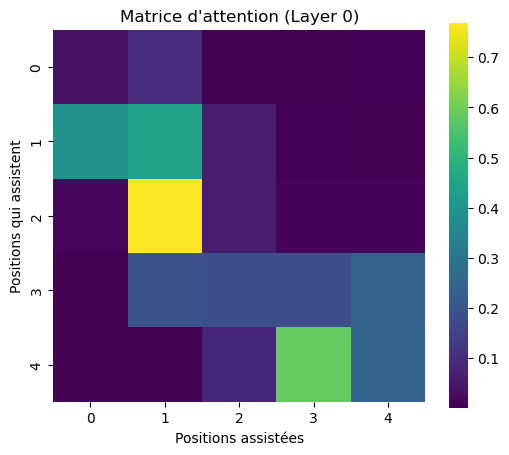

In [31]:
# exemple d’entrée (batch size 1)
sample = X_test[5].unsqueeze(0).to(device)
_ = model(sample)  # passage pour stocker l'attention

# extraire la matrice d'attention du premier bloc
attn_matrix = model.layers[0].attn_weights.squeeze(0).numpy()  # [T, T]
token_ids = sample.squeeze(0).argmax(dim=-1).cpu().numpy()
tokens = [id_to_char[i] for i in token_ids]

# Print la séquence
print("📝 Séquence :", "".join(tokens))
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
k = 5
sns.heatmap(attn_matrix[:k, :k], cmap="viridis", square=True, cbar=True)
plt.title("Matrice d'attention (Layer 0)")
plt.xlabel("Positions assistées")
plt.ylabel("Positions qui assistent")
plt.show()




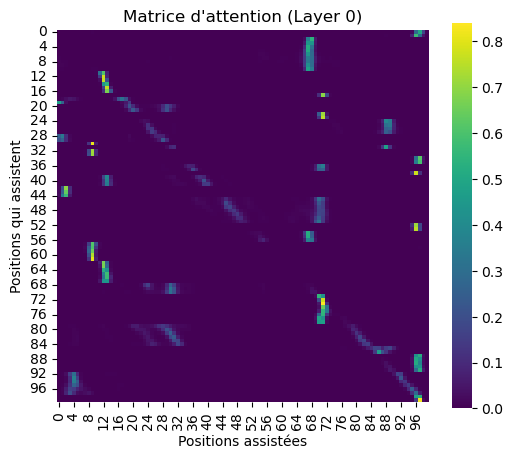

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(attn_matrix, cmap="viridis", square=True, cbar=True)
plt.title("Matrice d'attention (Layer 0)")
plt.xlabel("Positions assistées")
plt.ylabel("Positions qui assistent")
plt.show()


In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

def plot_attention_matrix(model, input_tensor, id_to_char, layer_idx=0, device='cpu'):
    """
    Affiche la matrice d'attention de la couche `layer_idx` sous forme de heatmap
    + print la séquence de lettres.
    
    Args:
        model: instance de AttentionOnlyTransformer
        input_tensor: [T, D] un batch de taille 1
        id_to_char: dico int -> lettre
        layer_idx: index de la couche d'attention à visualiser
    """
    model.eval()
    input_tensor = input_tensor.unsqueeze(0).to(device)  # [1, T, D]

    # Hook temporaire pour capturer l'attention
    attn_weights = {}

    def save_attn_weights(module, input, output):
        Q = module.Wq(input[0])
        K = module.Wk(input[0])
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (Q.size(-1) ** 0.5)
        attn = F.softmax(scores, dim=-1)
        attn_weights['matrix'] = attn.squeeze(0).detach().cpu().numpy()

    # Enregistre temporairement le forward hook
    handle = model.layers[layer_idx].register_forward_hook(save_attn_weights)

    # Propagation
    _ = model(input_tensor)

    # Supprimer le hook
    handle.remove()

    # Obtenir les lettres
    token_ids = input_tensor.squeeze(0).argmax(dim=-1).cpu().numpy()
    tokens = [id_to_char[i] for i in token_ids]

    # Print la séquence
    print("📝 Séquence :", "".join(tokens))


In [77]:
plot_attention_matrix(model, X_test[0], id_to_char, layer_idx=0, device=device)

📝 Séquence : HHCCCCCCCCCKKKKKKDLAEEDDBBBBAAIBIIHHJJHKKKFFFJJJJJJJHHCCCIIIIIKKKKKKEEEDDDDDDDDEEEEEEBBHHHHHLLLLLLHH


In [72]:
X_train[1], y_train[1]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.]]),
 tensor([ 3, 12, 12,  5, 12,  6, 12, 12, 10,  9, 12,  0, 12, 12, 10, 12, 12, 12,
         12,  6, 11, 12,  4, 12, 12, 12, 12,  9,  3,  4, 11,  0, 12, 12,  4, 12,
          7, 12, 12, 12, 12, 12, 12, 12, 12, 11, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 12, 12, 12, 12, 12, 12, 12,  4, 12, 12, 12,  7,  5, 12,  2, 12, 12,
          6, 12, 12, 12,  5, 12,  7, 12, 12, 12, 12, 12,  3, 12, 10, 12, 12, 12,
         12,  7, 12, 12, 12, 10, 12, 12, 12, 12]))

In [ ]:
def show_predictions(model, data_loader, id_to_char, device='cpu', num_batches=1):
    model.eval()
    model.to(device)
    with torch.no_grad():
        for i, (xb, yb) in enumerate(data_loader):
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)  # [B, T, C]
            preds = torch.argmax(logits, dim=-1)  # [B, T]

            for seq_idx in range(xb.size(0)):
                # Récupérer les tokens initiaux via l'embedding le plus proche
                input_seq = torch.argmax(xb[seq_idx], dim=-1)  # [T], car one-hot
                input_letters = [id_to_char[id.item()] for id in input_seq]
                true_seq = [id_to_char[id.item()] for id in yb[seq_idx]]
                pred_seq = [id_to_char[id.item()] for id in preds[seq_idx]]

                print(f"🔡 Input : {''.join(input_letters)}")
                print(f"🟢 Truth : {''.join(true_seq)}")
                print(f"🔵 Pred. : {''.join(pred_seq)}")
                print("-" * 30)

            if i + 1 >= num_batches:
                break


In [ ]:
show_predictions(model, test_loader, id_to_char, device=device, num_batches=20)

🔡 Input : HHCCCCCCCCCKKKKKKDLAEEDDBBBBAAIBIIHHJJHKKKFFFJJJJJJJHHCCCIIIIIKKKKKKEEEDDDDDDDDEEEEEEBBHHHHHLLLLLLHH
🟢 Truth : H_C________K_____DLAE_D_B___A_IBI_H_J_HK__F__J______H_C__I____K_____E__D_______E_____B_H____L_____H_
🔵 Pred. : ____________________________________________________________________________________________________
------------------------------
🔡 Input : IIIIILLLLAAAAAAAABBKKAFKAAAALLJJBDCEEEEEIEIIIFFDDDDDDFFFFFFFFFCBBBBHHHBBBDDDDDEAAAAGGGGGGGGGGGDDDDDE
🟢 Truth : I____L___A_______B_K_AFKA___L_J_BDCE____IEI__F_D_____F________CB___H__B__D____EA___G__________D____E
🔵 Pred. : _____LL_______________________JJ__C___________________________C____H________________________________
------------------------------
🔡 Input : ALLCCCABBBBDKFFHBCCCCCCCCCDDDDDDGGGGGGIIIIIFEEEBDDDDDDHHHAFFFFFEDDJJJHHHAFFFDJBBBBBBBGCCCCCCCCKFFHHH
🟢 Truth : AL_C__AB___DKF_HBC________D_____G_____I____FE__BD_____H__AF____ED_J__H__AF__DJB______GC_______KF_H__
🔵 Pred. : A__C__AB________________________________

In [ ]:
def train_model(model, train_loader, test_loader, epochs=10, lr=1e-3, device='cpu'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.eval()
        with torch.no_grad():
            total_val_loss = 0
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = loss_fn(pred, yb)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(test_loader)
        model.train()
        total_loss = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            pred = model(xb)  # [B, T, D]
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Évaluation

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


In [ ]:

train_model(model, train_loader, test_loader, epochs=20, lr=0.01)

/users/eleves-b/2022/elias.ben-rhouma/.local/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 100])) that is different to the input size (torch.Size([1, 100, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (13) must match the size of tensor b (100) at non-singleton dimension 2

In [ ]:
def evaluate_on_sequence(model, seq, char_to_emb, emb_to_char, empty_token='*', device='cpu'):
    model.eval()
    
    # 1. Encoder la séquence d'entrée
    emb_seq = [char_to_emb[c] for c in seq]

    x = torch.tensor(emb_seq, dtype=torch.float32).unsqueeze(0).to(device)  # [1, T, D]

    # 2. Prédiction
    with torch.no_grad():
        pred = model(x)[0]  # [T, D]
    

    # 3. Décoder la sortie
    def closest_embedding(vec):
        return min(emb_to_char.items(), key=lambda kv: np.linalg.norm(vec - np.array(kv[0])))[1]

    decoded_pred = [closest_embedding(p.cpu().numpy()) for p in pred]

    # 4. Cible attendue (compress + pad)
    target_seq = compress_and_pad_left(seq, empty_token)

    # 5. Affichage
    print("Séquence d’entrée      :", seq)
    print("Séquence compressée     :", target_seq)
    print("Séquence prédite (model):", decoded_pred)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def show_attention_maps(model, input_sequence, char_to_emb, layer_names=None):
    model.eval()
    seq_len = len(input_sequence)
    emb_seq = [char_to_emb[c] for c in input_sequence]
    x = torch.tensor(emb_seq, dtype=torch.float32).unsqueeze(0)  # [1, T, D]
    
    # Run forward to populate attn_weights
    with torch.no_grad():
        model(x)

    # Afficher les matrices d'attention de chaque couche
    for i, layer in enumerate(model.layers):
        print(i)
        attn = layer.att_weights[0]  # [T, T]
        plt.figure(figsize=(6, 5))
        sns.heatmap(attn, annot=True, fmt=".2f", cmap="Blues", cbar=True)
        title = layer_names[i] if layer_names else f"Attention Layer {i+1}"
        plt.title(title)
        plt.xlabel("Key position")
        plt.ylabel("Query position")
        plt.show()


0


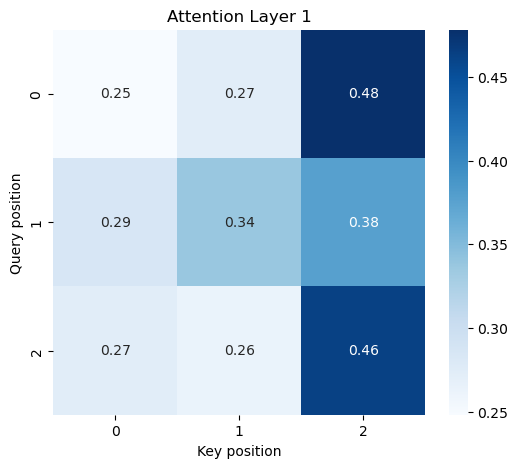

1


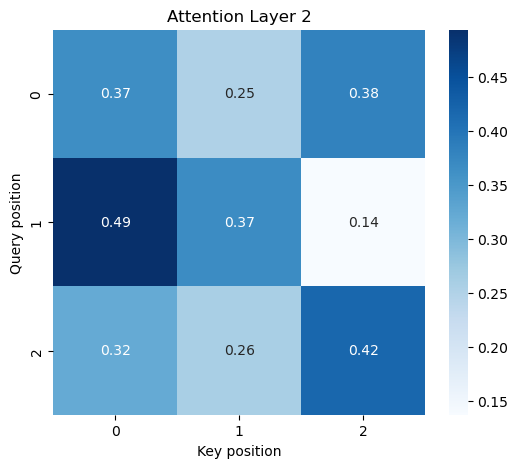

In [ ]:
sequence = ['A', 'B', 'A']
show_attention_maps(model, sequence, char_to_emb)

In [ ]:
# Exemple : test sur une séquence simple
sequences = [['B','B', 'B']]

for sequence in sequences:
    print("\nSéquence d'entrée :", sequence)
    evaluate_on_sequence(model, sequence, char_to_emb, emb_to_char, empty_token='*')



Séquence d'entrée : ['B', 'B', 'B']
Séquence d’entrée      : ['B', 'B', 'B']
Séquence compressée     : ['*', '*', 'B']
Séquence prédite (model): ['*', '*', '*']


In [ ]:
class AttentionOnlyEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

    def forward(self, src, src_mask=None, src_key_padding_mask=None, is_causal=None):
        attn_output, _ = self.self_attn(
            src, src, src, 
            attn_mask=src_mask, 
            key_padding_mask=src_key_padding_mask
        )
        src = self.norm1(src + self.dropout1(attn_output))
        return src


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=4, dim_feedforward=512, dropout=0.1, max_len=512):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        #encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        encoder_layer = AttentionOnlyEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(d_model, input_dim)

    def forward(self, src):
        x = self.input_proj(src)  # [B, T, D_model]
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        out = self.output_proj(x)  # [B, T, D_input] (embedding)
        return out


In [ ]:
def train_model(model, train_loader, test_loader, epochs=10, lr=1e-3, device='cpu'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(1, epochs + 1):
        model.train()
        total_train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = loss_fn(pred, yb)
                total_val_loss += loss.item()

        print(f"Epoch {epoch}/{epochs} | Train Loss: {total_train_loss/len(train_loader):.4f} | Val Loss: {total_val_loss/len(test_loader):.4f}")


In [ ]:
embedding_dim = X_train.shape[-1]

In [ ]:
model = TransformerModel(input_dim=embedding_dim, 
                         d_model=128, 
                         nhead=4,
                          
                         num_layers=2, 
                         dim_feedforward=8, 
                         dropout=0.1)

train_model(model, train_loader, test_loader, epochs=30, lr=1e-3)


Epoch 1/30 | Train Loss: 0.1673 | Val Loss: 0.1164
Epoch 2/30 | Train Loss: 0.1171 | Val Loss: 0.1036
Epoch 3/30 | Train Loss: 0.1079 | Val Loss: 0.1000
Epoch 4/30 | Train Loss: 0.1028 | Val Loss: 0.0964
Epoch 5/30 | Train Loss: 0.0977 | Val Loss: 0.0913
Epoch 6/30 | Train Loss: 0.0927 | Val Loss: 0.0878
Epoch 7/30 | Train Loss: 0.0895 | Val Loss: 0.0849
Epoch 8/30 | Train Loss: 0.0874 | Val Loss: 0.0835
Epoch 9/30 | Train Loss: 0.0860 | Val Loss: 0.0822
Epoch 10/30 | Train Loss: 0.0849 | Val Loss: 0.0810
Epoch 11/30 | Train Loss: 0.0842 | Val Loss: 0.0801
Epoch 12/30 | Train Loss: 0.0830 | Val Loss: 0.0790
Epoch 13/30 | Train Loss: 0.0821 | Val Loss: 0.0780
Epoch 14/30 | Train Loss: 0.0812 | Val Loss: 0.0772
Epoch 15/30 | Train Loss: 0.0801 | Val Loss: 0.0760
Epoch 16/30 | Train Loss: 0.0795 | Val Loss: 0.0751
Epoch 17/30 | Train Loss: 0.0789 | Val Loss: 0.0747
Epoch 18/30 | Train Loss: 0.0783 | Val Loss: 0.0738
Epoch 19/30 | Train Loss: 0.0776 | Val Loss: 0.0735
Epoch 20/30 | Train L

In [ ]:
# generate sequences
sequences = generate_sequences(5, 10, 5)


for sequence in sequences:
    print('___________________________')
    evaluate_on_sequence(model, sequence, char_to_emb, emb_to_char, empty_token='*')

___________________________
Séquence d’entrée      : ['E', 'D', 'B', 'B', 'A', 'B', 'B', 'A', 'B', 'A']
Séquence compressée     : ['*', '*', 'E', 'D', 'B', 'A', 'B', 'A', 'B', 'A']
Séquence prédite (model): ['*', '*', 'D', 'B', 'B', 'A', 'B', 'A', 'B', 'A']
___________________________
Séquence d’entrée      : ['D', 'A', 'A', 'A', 'B', 'D', 'D', 'B', 'D', 'C']
Séquence compressée     : ['*', '*', '*', 'D', 'A', 'B', 'D', 'B', 'D', 'C']
Séquence prédite (model): ['*', '*', 'D', 'A', 'A', 'B', 'D', 'B', 'D', 'C']
___________________________
Séquence d’entrée      : ['C', 'C', 'A', 'C', 'A', 'D', 'A', 'E', 'E', 'A']
Séquence compressée     : ['*', '*', 'C', 'A', 'C', 'A', 'D', 'A', 'E', 'A']
Séquence prédite (model): ['*', '*', '*', 'C', 'C', 'D', 'D', 'A', 'E', 'A']
___________________________
Séquence d’entrée      : ['D', 'A', 'B', 'E', 'E', 'D', 'B', 'E', 'B', 'B']
Séquence compressée     : ['*', '*', 'D', 'A', 'B', 'E', 'D', 'B', 'E', 'B']
Séquence prédite (model): ['*', '*', 'A', 'B'